# ディリクレ過程に基づく構造変化推定（MLPノンパラベイズ本より）
- MLPシリーズ「ノンパラメトリックベイズ」の§6の内容をPythonで実装した。

## モデル
- クラスタ毎に線形回帰モデルを仮定し、この回帰係数および観測ノイズの生成過程にCRPを用いる。
  - Gistだと下の数式が正しく表示されないかもしれません。
  - 線形回帰モデル
  $$y_t \sim {\cal{N}} (\theta_t^{\mathrm{T}}x_t, \sigma_t^2) $$
  - クラスタ毎の係数の生成過程
    - ステップtにおけるクラスタの総数を$K_t^+$と置き、第kクラスタの出現回数を$n_{t,k}$と表記する。
    - $k\in\{1,...,K_{t-1}^+\}$、すなわち既存のクラスタに属する場合
  $$P(\theta^{(k)}, \sigma_t^{(k)2}) = \frac{n_{t-1,k}}{t-1+\alpha}$$
    - $k=K_{t-1}^+ + 1$、すなわち新規クラスタの場合
  $$(\theta^{(K_{t-1}^+ +1)}, \sigma_t^{(K_{t-1}^+ +1)2}) \sim {\cal{N}}(\mu,\Sigma)IG(\frac{n_0}{2},\frac{\tau}{2})$$
  $$P(\theta^{(K_{t-1}^+ +1)}, \sigma_t^{(K_{t-1}^+ +1)2}) = \frac{\alpha}{t-1+\alpha}$$
    - $\mu, \Sigma, \tau$については下記の通り事前分布を設定する。
  $$\mu \sim {\cal{N}}(\mu_0, V_0), \qquad \Sigma^{-1} \sim W(\tau_0, \Sigma_0), \qquad \tau \sim Ga(\frac{m_0}{2}, \frac{\tau_0}{2})$$
  

## 1. 準備
### 1.1. ライブラリ

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

plt.style.use('ggplot')
np.random.seed(1234)

### 1.2. シミュレーションデータ

- 「§6.4 実験例」と同じ条件で作成する。

$$ y_t = 1 + 0.5t + u_t, \quad u_t \sim  {\cal{N}} (0, 0.3)　\qquad (1 \leqq t \leqq30) $$  

$$ y_t = 25 - 0.3t + u_t, \quad u_t \sim  {\cal{N}} (0, 0.1)　\qquad (31 \leqq t \leqq 60) $$  

$$ y_t = 1 + 0.1t + u_t, \quad u_t \sim  {\cal{N}} (0, 0.2)　\qquad (61 \leqq t \leqq90) $$

In [2]:
x = np.arange(1,91,1)
y = np.zeros(90)
y_tru = np.zeros(90)

y[:30] = 1 + 0.5*x[:30] + st.norm.rvs(loc=0, scale=np.sqrt(0.3), size=30)
y[30:60] = 25 - 0.3*x[30:60] + st.norm.rvs(loc=0, scale=np.sqrt(0.1), size=30)
y[60:] = 1 +0.1*x[60:] + st.norm.rvs(loc=0, scale=np.sqrt(0.2), size=30)
y_tru[:30] = 1 + 0.5*x[:30]
y_tru[30:60] = 25 - 0.3*x[30:60]
y_tru[60:] = 1 +0.1*x[60:]

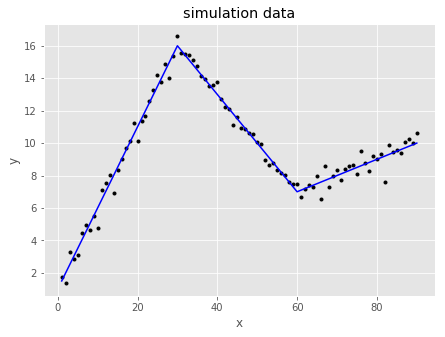

In [3]:
fig, ax = plt.subplots(figsize = (7,5))
ax.plot(x, y, marker=".", color="k", linewidth=0)
ax.plot(x, y_tru, color="b")
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_title('simulation data')
plt.show()

## 2. サンプリング用関数群
- ギブスサンプリングを行うための関数群を定義する
  - 本来クラスにまとめた方が簡潔になるが、試行用なので略。
  
まず潜在変数zのサンプリングから

### 2.1. 潜在変数z
- 既存のクラスタ数を$K^+$として,  
$k \in \{1,...,K^+\}$のとき
$$p(z_k | y_t,x_t,\theta^{(k)},z_{1:T}^{\t}) \sim {\cal{N}} (y_t | \theta^{(k)\mathrm{T}} , \sigma^{(k)2}) \times \frac{n_k^\t}{T-1+\alpha}$$
$k \notin \{1,...,K^+\}$のとき
$$p(z_k | y_t,x_t,\theta^{(k)},z_{1:T}^{\t}) \sim {\cal{N}} (y_t | \theta^{(new)\mathrm{T}} , \sigma^{(new)2}) \times \frac{\alpha}{T-1+\alpha}$$
$$(\theta^{(new)}, \sigma^{(new)}) \sim {\cal{N}} (\mu, \Sigma) IG(\frac{n_0}{2}, \frac{\tau}{2})$$

In [4]:
def sampler_z(t, yt, xt, theta, sigma_y, z, alpha, T, mu, sigma, n0, tau):
    k_plus, n_t = np.unique(z, return_counts=True)
    prob_z = np.empty(k_plus.shape[0]+1)#P(z_t = k) not notrmalize
    for k in k_plus:
        ## culculate n_k^¥t
        if(z[t]==k):
            n_kt = n_t[k_plus==k] - 1
        else:
            n_kt = n_t[k_plus==k]
        ## culculate probability s.t. z_t = k
        prob_z[k] = st.norm.pdf(x=yt, loc = np.dot(theta[k_plus==k], np.r_[xt,1]),\
                                    scale=sigma_y[k_plus==k])*(n_kt/(T-1+alpha))

    ## create new cluster
    theta_new = st.multivariate_normal.rvs(mean=mu, cov=sigma, size=1)
    sigma_new = np.sqrt(st.invgamma.rvs(a=n0/2, scale=tau/2, size=1))
    prob_z[-1] = st.norm.pdf(x=yt, loc = np.dot(theta_new, np.r_[xt,1]), scale=sigma_new)*(alpha/(T-1+alpha))
    
    ## sampling
    prob_z /= np.sum(prob_z)
    z_sample = np.random.choice(np.r_[k_plus, k_plus[-1]+1], size=1, p=prob_z)[0]#random.choice?
    return z_sample, theta_new, sigma_new
    ### return new z[t]

- クラスタが追加された場合に$\theta^{new}$と$\sigma^{new}$も返す必要がある
  - 当座は毎回$theta^{new}$を返す仕様とし, mainの側でサンプリング値$z_k$が新クラスタならば$theta$に$theta^{new}$を追加する処理を加えておく。
  - クラス化してしまえば内部で処理できるが、今回は手をつけていない。

### 2.2. パラメータ$\theta$
- これはクラスタ毎に定まる。$\cal{T}_k = \{t|z_t=k\}$に対して、
$$p(\theta^{(k)} | y,x,z,\sigma^{(k)}, \mu, \Sigma) \sim {\cal{N}}(\mu_k, \Sigma_k).$$
ただし
$$\Sigma_k^{-1} = \sum_{t \in \cal{T}_k}{\frac{x_t x_t^{\mathrm{T}}}{\sigma^{(k)2}}} + \Sigma^{-1}$$
$$\mu_k = \Sigma_k(\sum_{t \in \cal{T}_k}{\frac{y_t x_t}{\sigma^{(k)2}}} + \Sigma^{-1}\mu)$$

In [5]:
def sampler_theta(k, y, x, z, sigma_y, mu, sigma_inv):
    #print(mu, sigma_inv)
    sigma_yk = sigma_y[k]
    t_k = np.where(z == k)[0]
    x = np.c_[x.copy(), np.ones(x.shape[0])]#X_t = [X_t, 1]
    sigma_k_inv = sigma_inv.copy()
    mu_k_tmp = np.dot(sigma_inv.copy(), mu) #Sigma^-1 * mu
    for tt in t_k: # Sigma_(t in T_k)
        x_tt = x[tt][:,np.newaxis]
        sigma_k_inv += np.dot(x_tt,x_tt.T) / (sigma_yk**2)
        mu_k_tmp += (y[tt]*x[tt]) / (sigma_yk**2)
    sigma_k = np.linalg.inv(sigma_k_inv)
    mu_k = np.dot(sigma_k, mu_k_tmp)
    del mu_k_tmp
    return st.multivariate_normal.rvs(mean=mu_k, cov=sigma_k, size=1)
    ### return new theta[k]

### 2.3. 観測時ノイズの分散$\sigma^2$
- これもクラスタ毎に定まる。
$$p(\sigma^{(k)2} | y,x,z,\theta^{(k)},n_0, \tau) = IG(\sigma^{(k)2} | \frac{n_0+n_k}{2}, \frac{\tau_k}{2})$$
ただし
$$\tau_k = \tau + \sum_{t \in \cal{T}_k}{||y_t - \theta^{(k)\mathrm{T}}x_t||^2}$$
- 下記の関数ではsqrtを取り$\sigma^{(k)}$をサンプリングしている。

In [6]:
def sampler_sigma_y(k, y, x, z, theta, n0, tau):
    t_k = np.where(z == k)[0]
    n_k = t_k.shape[0]
    tau_k = tau
    for tt in t_k:
        resid = y[tt] - np.dot(theta[k],np.r_[x[tt],1])
        tau_k += np.dot(resid, resid)
    return np.sqrt(st.invgamma.rvs(a=(n0+n_k)/2, scale=tau_k/2))

### 2.4. $\mu$ ($\theta^{(new)}$の平均)
- サンプリング分布は
$$p(\mu | \theta^{(1:K^+)}, \Sigma, \mu_0, V_0) = {\cal{N}}(\mu | \mu_+, V_+)$$  
  ここで$\mu_0, V_0$は
$$V_0^{-1} = K^+\Sigma^{-1}+V_0^{-1}$$
$$\mu_+ = V_+(\Sigma^{-1}\sum_{k=1}^{K^+}{\theta^{(k)}}+V_0^{-1}\mu_0)$$

In [7]:
def sampler_mu(theta, sigma_inv, mu0, v0_inv):
    vp = np.linalg.inv(theta.shape[0] * sigma_inv + v0_inv )
    mup = np.dot(sigma_inv, np.sum(theta, axis=0)) + np.dot(v0_inv, mu0)
    mup = np.dot(vp, mup)
    return st.multivariate_normal.rvs(mean=mup, cov=vp)

### 2.5. $\Sigma$ ($\theta^{(new)}$の共分散行列)
- サンプリング分布は
$$p(\Sigma^{-1} | \theta^{(1:K^+)}, \mu, \nu_0, \Sigma_0) = W(\Sigma^{-1} | \nu_+, \Sigma_+)$$
ただし
$$\nu_+ = \nu_0 + K^+$$
$$\Sigma_+^{-1} = \Sigma_0^{-1} + \sum_{k=1}^{K^+}{(\theta^{(k)}-\mu)(\theta^{(k)}-\mu)}^\mathrm{T}$$

In [8]:
def sampler_Sigma_inv(theta, mu, nu0, sigma0_inv):
    nup = nu0 + theta.shape[0]
    sigmap_inv = sigma0_inv
    for ii in range(theta.shape[0]):
        tmp = (theta[ii] - mu)[:,np.newaxis]
        sigmap_inv += np.dot(tmp, tmp.T)
    return st.wishart.rvs(df=nup, scale=np.linalg.inv(sigmap_inv))

### 2.6. $\tau$ ($\sigma_y$の生成過程のパラメータ)
- サンプリング分布は
$$p(\tau | \sigma^{(1:K^+)}, n_0, m_0, \tau_0) = Ga(\tau | \frac{m_+}{2}, \frac{\tau_+}{2})$$
ただし
$$m_+ = m_0 + n_0K^+$$
$$\tau_0 = \tau_0 + \sum_{k=1}^{K^+}{\frac{1}{\sigma^{(k)2}}}$$

In [9]:
def sampler_tau(sigma_y, n0, m0, tau0):
    mp = m0 + n0*sigma_y.shape[0]
    taup = tau0 + np.sum(1/sigma_y**2)
    return st.gamma.rvs(a=mp/2, scale=taup/2)

## 3. サンプリング

### 3.1. 初期値設定

ハイパーパラメータ群

In [10]:
alpha = 1
n0 = 10

事前分布のパラメータ群

In [11]:
mu0 = np.array([0, 0])
v0_tmp = np.random.uniform(-10, 10, (2, 2))#np.array([[0.5, 0], [0,4]])
v0 = np.dot(v0_tmp, v0_tmp.T)
v0_inv = np.linalg.inv(v0)

nu0 = 2
sigma0_tmp = np.random.uniform(-10, 10, (2, 2))#np.array([[0.5, 0], [0,10]])#np.random.uniform(-1, 1, (2, 2))
sigma0 = np.dot(sigma0_tmp, sigma0_tmp.T) # positive definite
sigma0_inv = np.linalg.inv(sigma0)

m0 = 0.5
tau0 = 2 

パラメータの初期値

In [12]:
T = x.shape[0]

theta = np.array([[0.5,1], [-0.3, 25]])#, [0.1, 1]])
sigma_y = np.sqrt(np.array([0.2, 0.2]))#, 0.2]))
z = np.repeat(np.array([0,1]), 45)#np.repeat(np.array([0,1,2]), 30) #np.zeros(T, dtype="int")
print(z)
mu = st.multivariate_normal.rvs(mean=mu0, cov=v0)
sigma = st.wishart.rvs(df=nu0, scale=sigma0)
sigma_inv = np.linalg.inv(sigma)
tau = st.gamma.rvs(a=m0/2, scale=tau0/2)
print("mu : ", mu)
print("Sigma : ", sigma)
print("tau :", tau)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
mu :  [-9.56246008  7.33209689]
Sigma :  [[120.50695055 -49.34876924]
 [-49.34876924  23.14239448]]
tau : 0.24918271440471546


### 3.2. ギブスサンプリング
- 本では少なくとも12000ステップのサンプリングを行っていたが、ここでは2000ステップ（うちバーンイン1000ステップ）と設定した。

In [13]:
%%time
n_step = 2000
burnin = 1000
z_sample = np.zeros((n_step, T))
theta_sample = np.zeros((n_step, T, theta.shape[1]))

n_cluster = theta.shape[0]
z_unique = np.unique(z)
for step in range(n_step):
    #print(step)
    for tt in range(T):
        z_new, theta_new, sigma_new = sampler_z(tt, y[tt], x[tt], theta, sigma_y, z, alpha, T, mu, sigma, n0, tau)
        z[tt] = z_new
        if(z_unique is not np.unique(z)):
            z_unique = np.unique(z)
            # クラスタ数が増えた場合の処理
            if(n_cluster < z_unique.shape[0]):
                n_cluster += 1
                theta = np.r_[theta, [theta_new]]
                sigma_y = np.r_[sigma_y, sigma_new]
                #print(z_new, theta, sigma_y)
            # クラスタ数が減った場合の処理
            elif(n_cluster > z_unique.shape[0]):
                n_cluster -= 1
                theta = theta[z_unique]
                sigma_y = sigma_y[z_unique]
            #Zを0,1,2,...に置き換える処理
            for ii, z_val in zip(range(z_unique.shape[0]), z_unique):
                z[z==z_val] = ii

    for kk in range(n_cluster):
        theta[kk] = sampler_theta(kk, y, x, z, sigma_y, mu, sigma_inv.copy())
        sigma_y[kk] = sampler_sigma_y(kk, y, x, z, theta, n0, tau)
    mu = sampler_mu(theta, sigma_inv, mu0, v0_inv)
    sigma_inv = sampler_Sigma_inv(theta, mu, nu0, sigma0_inv.copy())
    tau = sampler_tau(sigma_y, n0, m0, tau0)

    z_sample[step] = z
    theta_sample[step] = np.r_[theta, np.repeat([np.repeat(np.nan,theta.shape[1])], T-theta.shape[0], axis=0)]

CPU times: user 4min 27s, sys: 1.26 s, total: 4min 29s
Wall time: 4min 31s


- 旧型のMacBookPro(Mid2012)でも、4分ほどで実行できている。
- sampler_thetaに渡すsigma_invは、copy()を取らないと内部で値が変化してしまう。
  - 内部でも代入はしていませんが、他のベクトルと内積を取った時に値が変わった？
  - これで丸一日を溶かしました。

In [14]:
np.unique(z)

array([0, 1, 2])

## 4. 結果
### 4.1. クラスタ数の分布

サンプリングにより得られたクラスタ数の配分は以下。

In [15]:
print(np.unique(np.max(z_sample[burnin:].astype('int')+1, axis=1), return_counts=True))

(array([2, 3, 4]), array([ 12, 957,  31]))


これを図示する。

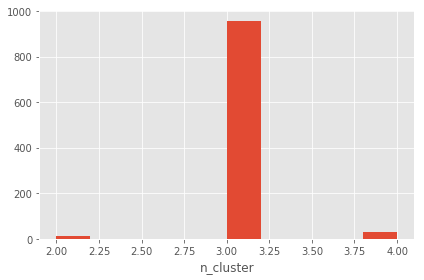

In [16]:
fig, ax = plt.subplots()
ax.hist(np.max(z_sample[burnin:].astype('int'), axis=1)+1)
ax.set_xlabel('n_cluster')
fig.tight_layout()

- 構造変化の数と同じクラスタ数=3が多数を占めており、わずかに2個・4個の場合も存在した。
  - 初期値はクラスタ数2であったから、正しくクラスタ数を推定できたことがわかる。
- MLP本の図（P.96, 図6.4）とは少し異なり、クラスタ数5以上は出現しなかった。
  - サンプリングのステップ数を増やせば出現する？

### 4.2. 傾き(勾配)の事後分布

In [17]:
z_after_burnin = z_sample[burnin:,:].astype('int')
theta_after_burnin = theta_sample[burnin:,:,0]

時刻0における傾きの事後分布は、下記のようにして取得できる。

In [18]:
grad = [theta_after_burnin[ii,z_after_burnin[ii,0]] for ii in range(z_after_burnin.shape[0])]
grad = np.array(grad)
grad.shape

(1000,)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


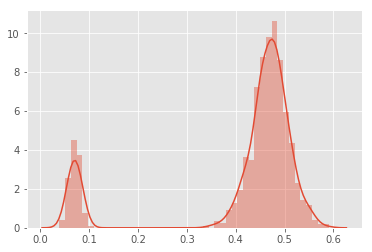

In [19]:
sns.distplot(grad)



この結果を全時刻で統合する。

In [20]:
grad_all = np.empty((T,n_step - burnin))
for tt in range(T):
    grad = [theta_after_burnin[ii,z_after_burnin[ii,tt]] for ii in range(z_after_burnin.shape[0])]
    grad_all[tt] = np.array(grad)

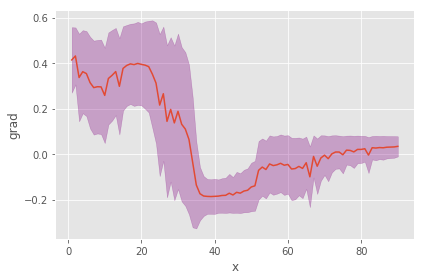

In [21]:
fig, ax = plt.subplots()
ax.plot(x, np.mean(grad_all, axis=1))
ax.fill_between(x, np.mean(grad_all, axis=1) +np.std(grad_all, axis=1), np.mean(grad_all, axis=1) -np.std(grad_all, axis=1),
               alpha=0.3, color="purple")
ax.set_xlabel('x')
ax.set_ylabel('grad')
fig.tight_layout()

- 元にしたMLP本の図（P.96, 図6.3）をほぼ再現できた。
  - x=30,60辺りで変動が起こっているらしいことは分かる。